<img src='../../img/anaconda-logo.png' align='left' style="padding:10px">
<br>
*Copyright Continuum 2012-2016 All Rights Reserved.*

# DataShader Pipeline

* Datashader allows you to tap into different points in the pipeline. 
* You can interject at many points. 
* You can e.g. save off the Xarray data after the aggregation before the image step in the pipeline. 
* This allows you to write your own transform function, which is the most popular customization, as the last step before creating an image.*
    

## Table of Contents
* [DataShader Pipeline](#DataShader-Pipeline)
	* [Set-Up](#Set-Up)
* [Pipeline Segments](#Pipeline-Segments)
	* [Data](#Data)
	* [Projection to Scene](#Projection-to-Scene)
	* [Aggregation to Aggregate](#Aggregation-to-Aggregate)
	* [Transformation to Image (or Other!)](#Transformation-to-Image-%28or-Other!%29)
	* [Color-mapping to Image](#Color-mapping-to-Image)
* [When to Use Datashader](#When-to-Use-Datashader)
	* [When *not* to use datashader](#When-*not*-to-use-datashader)
	* [When *to* use datashader](#When-*to*-use-datashader)
* [Data Prep](#Data-Prep)
	* [Big data](#Big-data)
* [Datashader Pipeline Demonstration (with defaults)](#Datashader-Pipeline-Demonstration-%28with-defaults%29)
	* [Step 1: Aggregate Data to Pixels](#Step-1:-Aggregate-Data-to-Pixels)
	* [Step 2: Transform Each Pixel to a Color](#Step-2:-Transform-Each-Pixel-to-a-Color)
* [Aggregations](#Aggregations)
* [Transformation](#Transformation)
* [Colormapping](#Colormapping)
	* [Coloring By Category](#Coloring-By-Category)
* [Real data](#Real-data)


## Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pipeline Segments

<img src='img/pipeline2.png'>

Note:
* Top row: verbs (methods)
* Bottom row: nouns (products)

## Data 

* Supported input Data Structures
      * Pandas DataFrames
      * Dask DataFrames

## Projection to Scene

* this is the hard part to implement
* taking data points and binning into pixels
* preserves all data points, just groups them into buckets
* doing the count would happen during aggregation
* Currently, you can project points and lines; soon to come is polygons
* e.g. cost of a taxi ride depends not just on pick-up point, but on the full path. Thats a line in this context, or a collection of lines.

## Aggregation to Aggregate

* example `mean()` or `sum()` or `count()`
* is expensive to run, so in Datashader uses numba to speed it up
* going from large number of datum to small, e.g. mean, sum
* Binning into pixels
* What is the output value for a single pixel
* cached aggregate output is saved to support many transformations being down without having to redo the aggregation.

## Transformation to Image (or Other!)

* e.g. filtering between two agregations like "pickup counts" and "dropoff counts"
* think "data analysis on down-sampled data"
* Best place to get started
* e.g. linear color map from lowest to highest value in aggregate
* are cheap to run can be easily customized
* to produce images, or something else.

## Color-mapping to Image

* Colormapping is really just another transfer function
    * You can string or pipe together several successive transfer functions
    * The datashader syntax will show colrmaps as transforms

# When to Use Datashader

## When *not* to use datashader

* Plotting less than 1e5 or 1e6 data points
    * it's a rasterization pipeline, so it's great for that but not other things
    * you lose interactivity because you lose connection to single data points
* When *every* datapoint matters; Bokeh/Matplotlib will render all of them
* For full interactivity (hover tools) with *every* datapoint

## When *to* use datashader

* Actual *big data*; when Bokeh/Matplotlib have trouble
* When the *distribution* matters more than individual points
* When you find yourself sampling (binning) to better understand the *distribution*

# Data Prep

## Big data

These functions create large samples of random numbers.

In [2]:
def make_rnd(loc=(0.5,0.5), std=1.0, size=300):
    o_x, o_y = loc
    x = np.random.normal(o_x,std,size=size)
    y = np.random.normal(o_y,std,size=size)

    return pd.DataFrame({'x':x,'y':y})

In [3]:
np.random.seed(1981)

def make_big_data(size=10000):
    s1 = make_rnd(loc=(-2,-2), std=0.5,  size=size)
    s2 = make_rnd(loc=(2,-2),  std=0.1,  size=size)
    s3 = make_rnd(loc=(2,2),   std=0.01, size=size)
    s4 = make_rnd(loc=(-2,2),  std=1.0,  size=size)
    s5 = make_rnd(loc=(0,0),   std=2,    size=size)
    data_sets = [s1,s2,s3,s4,s5]

    for idx, d in enumerate(data_sets):
        d['cat'] = 's' + str(idx+1)

    return pd.concat(data_sets, ignore_index=True)

This DataFrame contains 50,000 entries. It is still a challenge for traditional plotting tools.

In [4]:
df = make_big_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
x      50000 non-null float64
y      50000 non-null float64
cat    50000 non-null object
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
!conda install datashader

# Datashader Pipeline Demonstration (with defaults)

In [5]:
import datashader as ds
import datashader.transfer_functions as tf

ModuleNotFoundError: No module named 'datashader'

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
Three steps in the Datashader Pipeline:<br><tt>canvas, aggregation, image</tt>
</big></big>
<br><br>
</div>

Three most important objects:
* **canvas** determines plot size and data ranges
* **aggregation** collects points onto the Canvas pixels according to a reducing function (linked to canvas object)
* **image** the raster image to display; output of `shade()`

Let's look a very simple 2-step version of the above procedure using datashader defaults.

## Step 1: Aggregate Data to Pixels

By default indivdual data points are counted for each pixel in a 600x600 image.

Unlike *binning* by value ranges in traditional plotting, **aggregation** follows the image size.

In [10]:
canvas = ds.Canvas()
agg = canvas.points(df,'x','y')
agg

<xarray.DataArray (y_axis: 600, x_axis: 600)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y_axis   (y_axis) float64 -7.124 -7.098 -7.072 -7.046 -7.02 -6.994 ...
  * x_axis   (x_axis) float64 -7.694 -7.668 -7.642 -7.616 -7.589 -7.563 ...

<div class='alert alert-success'>
<img src='img/topics/Advanced-Concept.png' align='left' style='padding:10x'>
<br>
<tt>xarray</tt> is related to Pandas and Numpy and many of the same types of operations are supported.
<br><br>
</div>

Let's figure out where the most dense point is. It should near the `s3` category.

In [11]:
agg.to_dataframe(name='agg').sort_values('agg', ascending=False).head()

,,agg
y_axis,x_axis,
1.976591,1.984541,4684
2.002518,1.984541,3148
1.976591,2.010771,826
2.002518,2.010771,579
1.976591,1.958311,395


Let's convince ourselves that we have **5** categories with the above mean and standard deviations.

In [12]:
df.groupby('cat').agg(['std', 'mean']).swaplevel(0,1, axis='columns').sort_index(axis='columns')

mean                 std          
            x         y         x         y
cat                                        
s1  -1.997155 -2.009297  0.501048  0.497433
s2   1.999987 -1.998922  0.099869  0.098848
s3   1.999979  2.000001  0.010165  0.010008
s4  -1.988841  2.010630  1.006096  1.001049
s5  -0.013321  0.014002  1.988684  1.982636

## Step 2: Transform Each Pixel to a Color

How do you set the color of a singel pixel?

How do the values in the aggregation map to colors? Look at the min and max values. Linear, log, and histogram equalization are al methods of how to map/bin values to single colors.
This historgram bins are all equal width measure in values units.


Unlike histograms with static bin counts:
* more data per pixel means a continuously darker color (no oversaturation)
* interpolate between light blue and dark blue using the data counts per pixel along with opacity
* look closely, a visible color is plotted anywhere there are points (alpha=0 where there is no data)

A lognorm histogram with *well chosen* bins was required in matplotlib.

Here we're interpolating the rgb values of only two colors according to [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization).

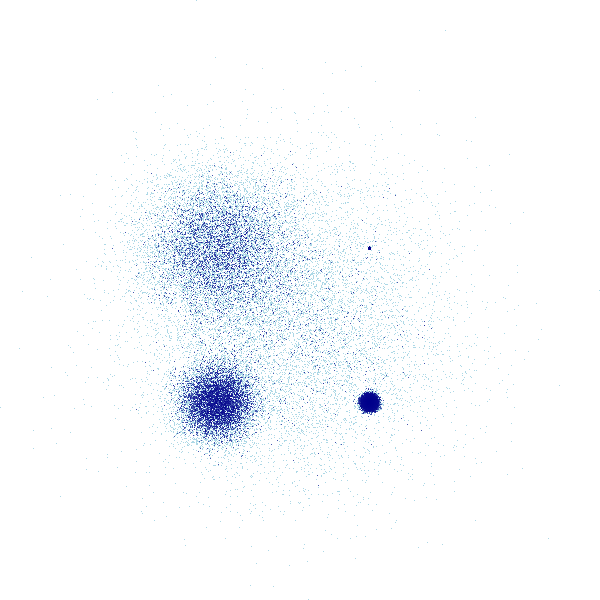

In [13]:
img = tf.shade(agg, how='eq_hist') # eq_hist is default
img

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
The one-line call to perform a eq_hist interpolation.
</big></big>
<br><br>
</div>

Wall time: 36.6 ms


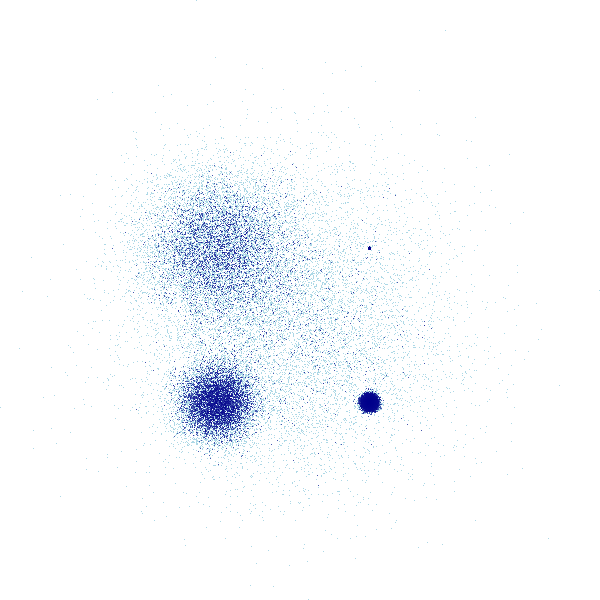

In [14]:
%time tf.shade(ds.Canvas().points(df,'x','y'))

A much larger data set with 10 million points. 2 million points for each of the 5 distributions.

In [37]:
df_big = make_big_data(int(2e6))
df_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 3 columns):
x      float64
y      float64
cat    object
dtypes: float64(2), object(1)
memory usage: 228.9+ MB


The 5 regions are still quite visible.

Wall time: 562 ms


C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


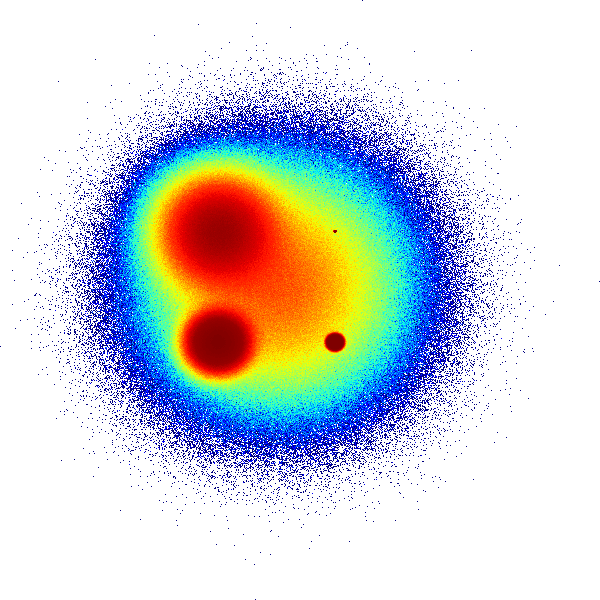

In [40]:
%time tf.shade(ds.Canvas().points(df_big,'x','y'), cmap=jet)

Compare with a linear interpolation.

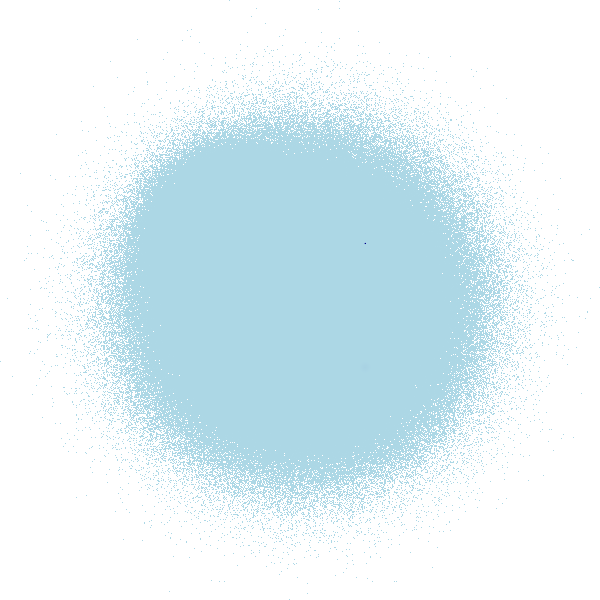

In [17]:
tf.shade(ds.Canvas().points(df_big,'x','y'), how='linear')

In [18]:
del df_big

# Aggregations

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
You must choose how data is to be mapped (*aggregated*) to pixels
</big></big>
<br><br>
</div>

Aggregation is the most important and time consuming step in Datashading.

Pandas-like reductions are allowed
* count (default)
* sum
* mean
* std
* by category (`count_cat`)

Count the number of points per unique category, per pixel.

* Canvas is the "scene"
* First thing to create when doing a datashader plot
* Defining the x and y ranges defines the raster grid needed for doing the projection

In [19]:
canvas = ds.Canvas(plot_width=200, plot_height=200)

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
Columns representing categorical data must be transformed to the <tt>category</tt> dtype.
</big></big>
<br><br>
</div>

Now let's use the x, y columns as point glyphs.

Let's perform an aggregation `count_cat`, and we're performing the aggregation within categories stored in the `cat` column. There happens to be 5 different categories represented in the `cat` column, so there will be 5 aggregations performed, one for each category.

Typically, these are the columns where you might perform groupby operations.

In [20]:
df['cat'] = df['cat'].astype('category')

In [21]:
aggc = canvas.points(df, 'x', 'y', ds.count_cat('cat'))
aggc

<xarray.DataArray (y_axis: 200, x_axis: 200, cat: 5)>
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       ..., 
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ..., 
        [0, 0,

# Transformation

Now we show an example of a transfer function applied to an aggregation, in this case, an interpolation applied to the single category `s2`.

*Note: More operations can be performed on the xarray aggregated data.*

More about [indexing](http://xarray.pydata.org/en/stable/indexing.html) and [computation](http://xarray.pydata.org/en/stable/computation.html) with xarray

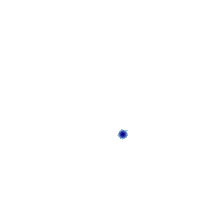

In [22]:
tf.shade(aggc.sel(cat='s2'))

Another example of a transformation.

Secondary aggregation of datapoints per pixel for only the s2 and s5 datasets.

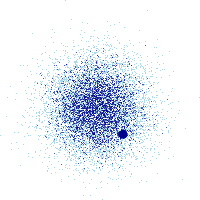

In [23]:
agg_s2_s5=aggc.sel(cat=['s2', 's5']).sum(dim='cat')
tf.shade(agg_s2_s5)

The *aggregated* information can be filtered. Here's the 99th percentile by density. It nearly removes the larger data set.

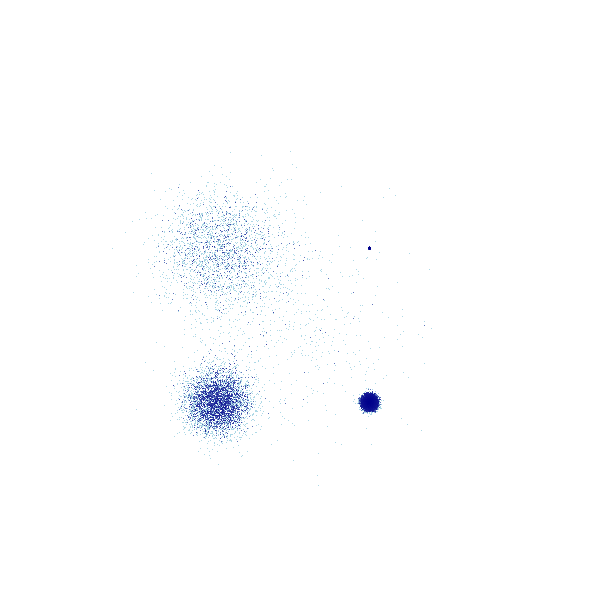

In [24]:
tf.shade(agg.where(agg>=np.percentile(agg,99)))

# Colormapping

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
Map a scalar aggregate bin value into an RGB color and an alpha (opacity) value
</big></big>
<br><br>
</div>

Color palettes from Datashader, Bokeh and Matplotlib are supported. A custom list of color vlaues as RGB, hex or CSS colors names can also be provided.

In [25]:
canvas = ds.Canvas(plot_height=400, plot_width=400)
agg = canvas.points(df,'x','y')

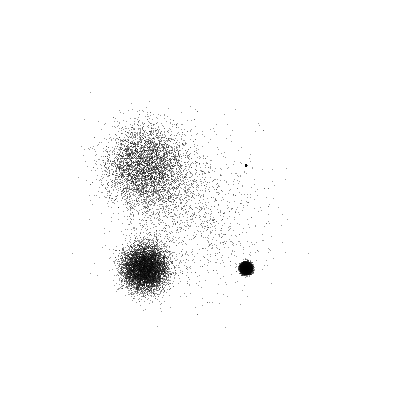

In [26]:
from datashader.colors import Greys9
tf.shade(agg, cmap=reversed(Greys9))

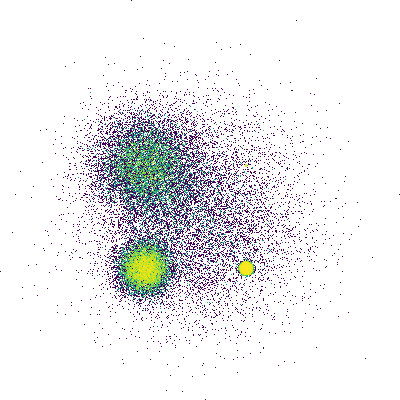

In [27]:
from datashader.colors import viridis
tf.shade(agg, cmap=viridis)

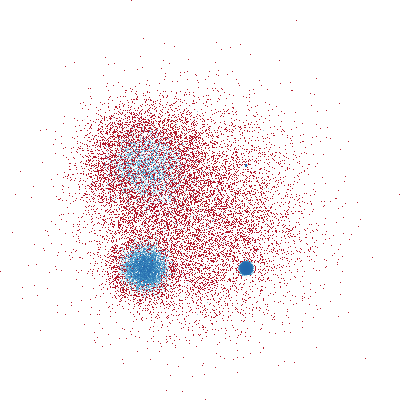

In [28]:
from bokeh.palettes import RdBu9
tf.shade(agg, cmap=reversed(RdBu9))

C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


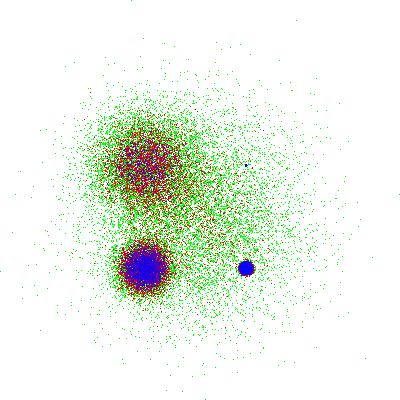

In [29]:
from matplotlib.cm import brg_r
tf.shade(agg, cmap=brg_r)

C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


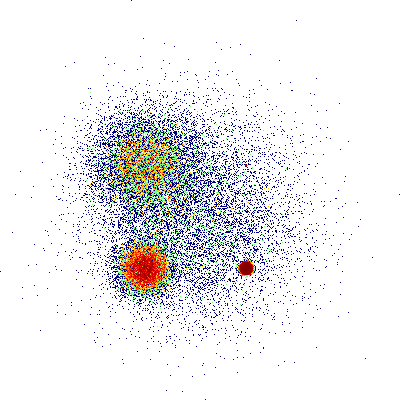

In [30]:
from matplotlib.cm import jet
tf.shade(agg, cmap=jet)

## Coloring By Category

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
<tt>tf.shade()</tt> allows a direct mapping from category name to color with <tt>color_key=</tt>.
</big>
<br>Can be a dictionary lookup or list of colors.</big>
<br><br>
</div>

C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\datashader\transfer_functions.py:258: RuntimeWarning: invalid value encountered in true_divide
  r = (data.dot(rs)/total).astype(np.uint8)
C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\datashader\transfer_functions.py:259: RuntimeWarning: invalid value encountered in true_divide
  g = (data.dot(gs)/total).astype(np.uint8)
C:\Users\AngelSparkles\AppData\Local\Continuum\Anaconda3\envs\Python 34\lib\site-packages\datashader\transfer_functions.py:260: RuntimeWarning: invalid value encountered in true_divide
  b = (data.dot(bs)/total).astype(np.uint8)


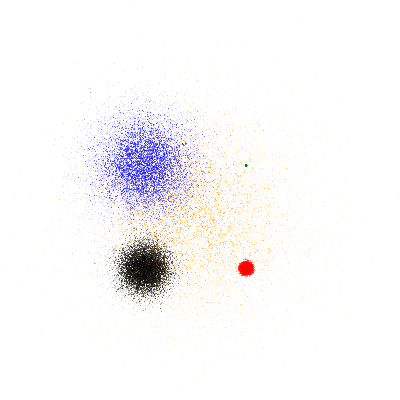

In [31]:
colors = ['black', 'red', 'green', 'blue', 'orange']

canvas = ds.Canvas(plot_height=400, plot_width=400)
agg = canvas.points(df,'x','y', ds.count_cat('cat'))
tf.shade(agg, color_key=colors, how='eq_hist')

# Real data

<a href='./Datashader_taxi.ipynb' class='btn btn-primary btn-lg'>NYC Taxi Data</a>